# Controling a line network
In this notebook we try to control a line network such that the state of nodes envolve from the initial conditions to the desired endstate. We represent the control problem as a state-space (ODE) system and we try to control it using close feedback loop and reinforcement learing. 

A line network is a directed network with 4 nodes, where each node is pointing to the asending node (`x->y` iff `y=x+1`). The network is defined by adjacency matrix $A \in \mathbb{R}^{nxn}$, we define input matrix $B \in \mathbb{R}^{nxm}$. A state of the network is denoted by $x_t \in \mathbb{R}^{n}$ and the control signal $u(t) \in \mathbb{R}^{m}$, which forms a linear system:
$$\frac{d}{dt}(t) = Ax(t) + Bu(t)\tag{1}$$
$$y(t) = Cx(t) \tag{2}$$
with solution:
$$x(t) = e^{At}x_0 + \int_0^t e^{A(t - \tau)}Bu_\tau d\tau \tag{3}$$

$A = \begin{bmatrix}
0 & 0 & 0 & 0\\
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0
\end{bmatrix} 
B = \begin{bmatrix}
1\\
0\\
0\\
0
\end{bmatrix}$  
detail solution can be found in the Apendix.

According to _Controllability of complex networks_ [5], $B$ is a result of minimal matching, where we are controling only unmatched nodes, which in the _line network_ case, is the first node.

In [1]:
import control
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.integrate import odeint, quad_vec, quad
from scipy.linalg import expm

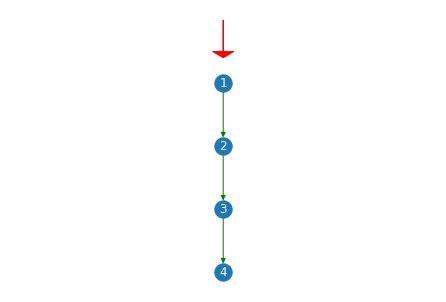

In [2]:
n = 4
G = nx.DiGraph()
G.add_edges_from([(i, i+1) for i in range(1, n)])

pos={i + 1: np.array([0, -i]) for i in range(n)}
nx.draw(G, pos, with_labels=True, font_color="white", edge_color="g")
plt.arrow(0, 1, 0, -0.5, head_width=0.0005, head_length=0.1, width=0, color="r")
plt.show()

A = np.array([[0, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0],[0, 0, 1, 0]])
B = np.array([[1], [0], [0], [0]])

## Is the network controlable? 
In order to check the network controlabillity we can provide two equivalent tests - _structural control_ (4) and the Popov-Belevitch-Hautus (PBH) test [1,5].

### Structural controllability
$$\mathscr{C} = [B, AB, A^2,...,A^{n-1}B] \tag{4}$$
Network is controllable iff $rank(\mathscr{C}) = n$ (Kalman's rank conditon).

In [3]:
C = control.ctrb(A, B)
print(f"C = {C}")
print(f"Rank of matrix C is {np.linalg.matrix_rank(C)}")

C = [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Rank of matrix C is 4


### Popov-Belevitch-Hautus
$$[(A-\lambda I)B]\tag{5}$$
Network is controllable iff the column rank of $(5)$ is $n$ for all $\lambda \in \mathbb{C}$. "Thus, for $[(A − \lambda I) B]$ to have rank $n$, the columns in $B$ must have some component in each of the eigenvector directions associated with $A$ to complement the null-space of $A − \lambda I$." [1]

In [4]:
eigs, _ = np.linalg.eig(A)
print(f"Eigenvalues of matrix A are {list(eigs)}")

for e in eigs: 
    print(f"Column rank for λ={e} [(A-{e}I)B]={np.linalg.matrix_rank(np.append(A - e * np.eye(n), B, axis=1).T)}")

Eigenvalues of matrix A are [0.0, 0.0, 0.0, 0.0]
Column rank for λ=0.0 [(A-0.0I)B]=4
Column rank for λ=0.0 [(A-0.0I)B]=4
Column rank for λ=0.0 [(A-0.0I)B]=4
Column rank for λ=0.0 [(A-0.0I)B]=4


### Using PBH to estimate minimal number of controlers
> [...], the PBH controllability test suggests that ($A$, $B$) is controllable if and only if there is no left eigenvector of $A$ orthogonal to all the columns of $B$. In other words, the columns of $B$ must have a component in each eigendirection of $A$. Recall that for an eigenvalue $\lambda_0 \in \lambda(A)$, its algebraic multiplicity is the multiplicity of $\lambda_0$ as a root of the characteristic polynomial $p(\lambda) = det(A−\lambda I)$. Its geometric multiplicity is the maximal number of linearly independent eigenvectors corresponding to it. Hence, the number of control inputs must be greater than or equal to the largest geometric multiplicity of the eigenvalues of $A$ [...] 
In other words, the minimum number of control inputs (or equivalently the minimum number of driver nodes) is determined by the maximum geometric multiplicity of the eigenvalues of $A$, i.e.
>
>$$N_D = max_i\{\mu(\lambda_i)\},$$ 
>where $\mu(\lambda_i) = dimV_{\lambda_i} = N - rank(\lambda_iI_N − A)$ is the geometric multiplicity of A’s eigenvalue $\lambda_i$, representing the dimension of its eigenspace. [4,9]

In [5]:
print(f"M_D = {max([n - np.linalg.matrix_rank(A - e * np.eye(n)) for e in eigs])}")

M_D = 1


## Close feedback loop
Firstly, we will control the network $(1)$ using a close feedback loop, where $u(t) = -Kx(t)$, therefore, we can reframe the original equation (1) into: 
$$\frac{d}{dt}x(t) = (A - BK)x(t) \tag{6}$$
In order to use $C$ as our output, we need to check if the system is observable.

### Observability
We call system _observable_ iff it is possible to estimate any state of $\xi \in \mathbb{R}^n$ from the histiory of $y(t)$.
$$\mathscr{O} = [C, CA, CA^2,...,CA^{n-1}]^T \tag{7}$$
The system is observable iff $rank(\mathscr{O})=n$.

In [6]:
C = np.eye(4)  # The network is observable for np.diag(np.array([0,0,0,1])) as well
O = control.obsv(A, C)
print(f"Rank of matrix C is {np.linalg.matrix_rank(O)}")

Rank of matrix C is 4


We model (6) as $\frac{d}{dt}x(t) = (A - BK)(y(t) - w_r)$, where $w_r$ is the reference position (expected endstate).
### _Place_ $A-BK$ into some non-positive eigen values

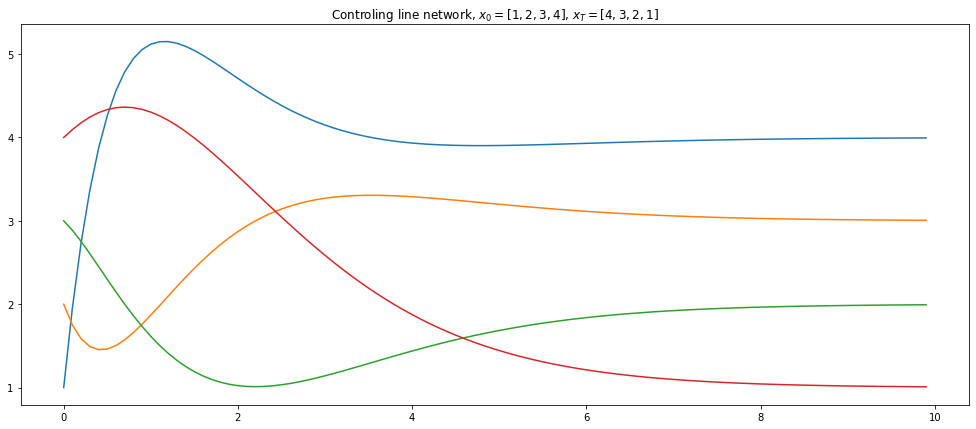

In [7]:
# Some non-positive eigen values to "place" matrix (A-BK) to
eigs = np.array([-1, -1.1, -1.2, -1.3])
K = control.place(A, B, eigs)

x0 = np.array([1, 2, 3, 4])
wT = np.array([4, 3, 2, 1])

def line_network(y, t, K):
    x_diff = (y - wT)
    u = np.dot(-K, x_diff)
    return np.dot(A, x_diff) + np.dot(B, u)

t = np.arange(0, 10, 0.1)
y = odeint(line_network, x0, t, args=(K, ))

plt.figure(figsize=(17, 7))
plt.title(f"Controling line network, $x_0={list(x0)}$, $x_T={list(wT)}$")
plt.plot(t, y)
plt.show()

## Kalman filter

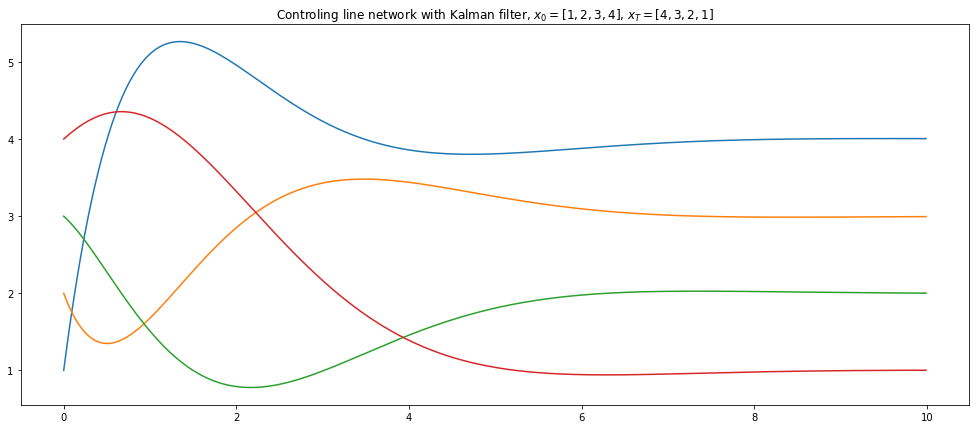

In [8]:
# Design LQR controller
Q = np.eye(n)
R = .0001
K_hat, S, E = control.lqr(A, B, Q, R)

t = np.arange(0, 10, 0.01)
y = odeint(line_network, x0, t, args=(K_hat, ))

plt.figure(figsize=(17, 7))
plt.title(f"Controling line network with Kalman filter, $x_0={list(x0)}$, $x_T={list(wT)}$")
plt.plot(t, y)
plt.show()

## Reinforcement Learning
A side from the _classical_ control theory we can try to control the line network by a Reinforcement Learnig (RL). The fundamental idea of RL is an agent taking actions within a well defined enviroment, each action is rewarded. Agent by doing actions learns which action provides the highest reward [3]. Before jumping on a specific example and reinforcement model, lets consider a _dummy solution_.

### _Dummy_ solution
As we have seen that the network is controlable and without any advance control theory, we can get a network into any state. The signal sent by the $u_t$ propagates through the network. So, if $u_t=1$ node $x_{t}^1=1$, in next time step it will be propagated to node 2 $x_{t+1}^2=1$ and so on. Therefore, by setting $u$ as $u_{t} = x_{t+i-1}^i$ we can _cook_ any state we wish. 

We will try to train a RL model to discover this "state propagation".

The initial state is $x_0=[1,2,3,4]$ and the endstate, where we want to get the network is $x_T = [4,3,2,1]$. However, the values of the initial and the final state are in $\{0,1,2,3\}$ and we will use a _discrete_ version of the state-space (1):
$$x_{t+1} = Ax_t + Bu_t \tag{8}$$
we can use an integer values for $u \in \{0,1,2,3,4\}$. 

_However, all states of $x_t$ are in $\{0,1,2,3,4\}^n$, we can asign to each possible state a pentanary number in base 5._

In [9]:
def pentanary(state: np.array) -> int:
    num = "".join([str(int(a)) for a in state])
    return int(num, 5)

assert pentanary(np.array([1,2,3,4])) == 194

## Q-learning
The frist RL model we use is _Q-learning_ which is a _temporal-difference learning_ [3]. The model recognise the action which led into a finial state and propagates the reward to the pervious actions, which in fact learns what is the optimal strategy.


$$Q(x_t, u_t) \leftarrow Q(x_t, u_t) + \alpha [R_{t+1} + \gamma max_{u} Q(x_{t+1}, u) - Q(x_t, u_t)] \tag{9}$$
where:   
• $R_t$ is a reward at time $t$  
• $Q$(x, u) is an estimate for action (actuation, control signal) $u$ in state $x$  
• $\alpha \in (0,1)$ step size parameter  
• $\gamma \in (0,1)$ is discounting-rate parameter  

We will use an $\epsilon$-greedy policy, where with probability $\epsilon$ we make a random step and for $(1-\epsilon)$ we play optimally according to the best available action [3]. Once the network has reached the desired endstate, we reward that action with 1 otherwise reward is 0. We train the Q-learning for 10000 _episodes_ over 20 time steps, then we run a control episode and observe if the model managed to control the network from $x_0 = [1,2,3,4]$ to $x_T=[4,3,2,1]$. 

In other words, we want the Q-learning to send control signals in sequence of $u_{\tau+0}=1, u_{\tau+1}=2, u_{\tau+2}=3, u_{\tau+3}=4$.

In [10]:
q = {}

epsilon = 0.01
gamma = 0.99
alpha = 0.5

desired_state_pentanary = pentanary(wT)

def episode(max_iter=20, halt=False):
    def model(_s, _a):
        return (np.dot(A, _s) + np.dot(B.T, _a))[0]
        
    state = x0
    action = 0
    reward_t = 0
    history = [state]
    for _ in range(max_iter):
        state_pentanary = pentanary(state)
        
        if np.random.rand() < epsilon:
            # Explore strategy
            best_a = np.random.randint(0, 5)
            
        else:
            # Exploit strategy
            q_max = -1
            best_a = -1
            for a in range(0, 5):
                temp_state = model(state, a)
                temp_state_pentanary = pentanary(temp_state)
                if q.get((temp_state_pentanary, a), 0.1) > q_max:
                    q_max = q.get((temp_state_pentanary, a), 0.01)
                    best_a = a
            
        temp_state = model(state, best_a)
        temp_state_pentanary = pentanary(temp_state)
        q_max = q.get((temp_state_pentanary, best_a), 0.01)
        
        reward = (temp_state_pentanary == desired_state_pentanary) * 1
        reward_t += reward
        q_current = q.get((state_pentanary, action), 0.01)
        q[(state_pentanary, action)] = min(q_current + alpha * (reward + gamma * q_max - q_current), 1)
        
        state = temp_state
        action = best_a
        history.append(state)
        if reward and halt:
            return history, reward_t
        
    return history, reward_t

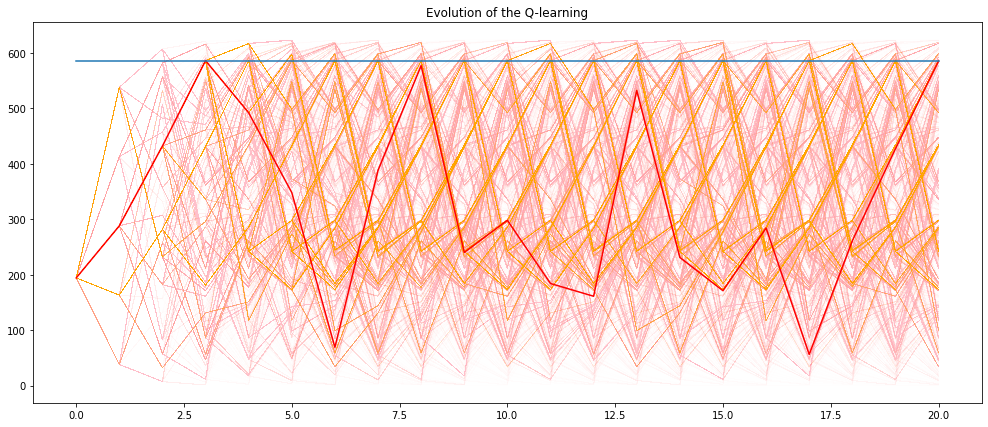

In [11]:
reward_t = []
m = 30000
l = 21
# Training
plt.figure(figsize=(17, 7))
plt.title(f"Evolution of the Q-learning")
color = "pink"
for e in range(m):
    history, reward = episode()
    reward_t.append(reward)
    plt.plot([pentanary(h) for h in history[:l]], alpha=0.01, color=color, linewidth=0.5)
    if e == int(4 * m / 5):
        color = "orange"
    
history, _ = episode()
plt.plot([pentanary(h) for h in history[:l]], color="red")
plt.plot([pentanary(wT)]*l)
plt.show()    

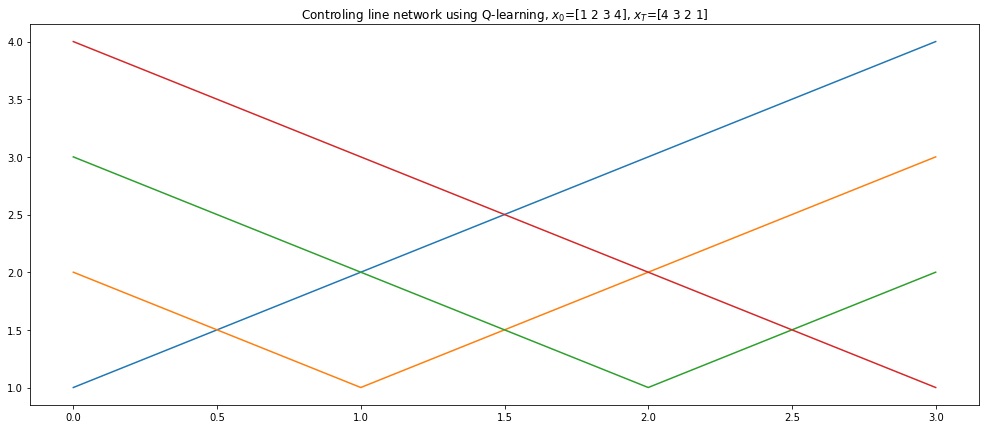

In [12]:
history, _ = episode(halt=True)
plt.figure(figsize=(17, 7))
plt.title(f"Controling line network using Q-learning, $x_0$={x0}, $x_T$={wT}")
plt.plot(history)
plt.show()

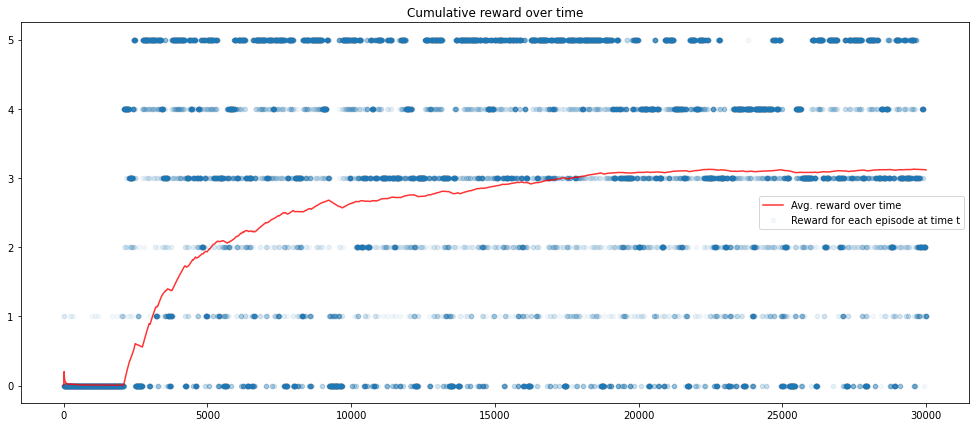

In [13]:
plt.figure(figsize=(17, 7))
plt.title(f"Cumulative reward over time")
plt.scatter(np.arange(m), reward_t, alpha=0.05, s=20, label="Reward for each episode at time t")
plt.plot(np.cumsum(reward_t) / np.arange(1, len(reward_t) + 1), alpha=0.8, color="red", label="Avg. reward over time")
plt.legend()
plt.show()

# Conclusion
We managed to control a simple _4-node_ line network using a close feedback loop system and Q-learning technique. 

## Apendix
### Solution for the linear system $\frac{d}{dt}x(t) = Ax(t) + Bu(t)$
This linear system is a first-order linear (inhomogeneous) diferentional equation, which can be solved by integrating factor $f(x) = e^{\int^xP(\lambda)d\lambda}$.  
 
$$\frac{d}{dt}x(t) - Ax(t) = Bu(t)$$
$$e^{-\int^t_0Ad\lambda}x(t)=\int^t_0e^{\int^\tau_0-Ad\lambda}Bu(\tau)d\tau + C$$
$$e^{-A[\tau]_0^t}x(t) = \int^t_0e^{-A[\lambda]^\tau_0}Bu(\tau)d\tau + C$$
$$e^{-At}x(t) = \int^t_0e^{-A\tau}Bu(\tau)d\tau + C$$
$$x(t) = \int^t_0e^{A(t-\tau)}Bu(\tau)d\tau + e^{At}C$$
$$x(t) = e^{At}x(0) + \int^t_0e^{A(t-\tau)}Bu(\tau)d\tau$$

## References
[1] Brunton, S., & Kutz, J. (2019). Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control. Cambridge: Cambridge University Press. doi:10.1017/9781108380690  
[2] Brunton, S, (2017). Linear Quadratic Regulator (LQR) Control for the Inverted Pendulum on a Cart [Control Bootcamp], https://www.youtube.com/watch?v=1_UobILf3cc  
[3] Sutton, R. S. & Barto, A. G. (2018 ), Reinforcement Learning: An Introduction, The MIT Press.  
[4] Liu, Y. Y. & Barabasi, A. L. (2016), Control Principes of Complex Networks, 10.1103/RevModPhys.88.035006  
[5] Liu, Y. Y., Slotine, J. J. & Barabási, A. L. (2011), Controllability of complex networks. Nature 473, 167–173. https://doi.org/10.1038/nature10011  
[6] Baggio, G., Bassett, D.S. & Pasqualetti, F. (2021), Data-driven control of complex networks. Nat Commun 12, 1429. https://doi.org/10.1038/s41467-021-21554-0  
[7] Sun, Jie and Motter, Adilson E. (2013), Controllability Transition and Nonlocality in Network Control, https://link.aps.org/doi/10.1103/PhysRevLett.110.208701  
[8] Cornelius, S., Kath, W. & Motter, A. (2013), Realistic control of network dynamics. Nat Commun 4, 1942 . https://doi.org/10.1038/ncomms2939  
[9] Zhengzhong Yuan et al (2014), _Exact controllability of multiplex networks_ New J. Phys. 16 103036